In [ ]:
%cd ~/TOA_causal

In [2]:
import torch
import os
from tqdm import tqdm
import numpy as np
from TOA.mbfdunetln import MBPFDUNet
from ANDMask.adam_flexible_weight_decay import AdamFlexibleWeightDecay
from torch.optim.lr_scheduler import MultiStepLR
from TOA.train import createForwMat
from utils.causal_utils import train,validation,testing,computing_metrics,load_traindataset,load_testdataset,load_ckp
from utils.noncausal_utils import load_traindataset_nc,train_nc

In [3]:
batchsize = 3 #per environment
val_percent = 440.0/2216.0 # 440 para validacion, 1776 para train
le = 5
epochs = 50
lr = 1e-4
wd= 1e-6
agreement_threshold = 0.3 
cache_dir = '../data/'
fecha = '260722_15'
continue_training = False

In [4]:
if torch.cuda.is_available():
	device = torch.device("cuda")
else:
	device = torch.device("cpu")
print(f"Device to be used: {device}")

##Load train dataset	
train_loaders, val_loader = load_traindataset(cache_dir,val_percent,batchsize,val_batchsize=40,le = le)

##Model and optimizer
model = MBPFDUNet().to(device=device)
optimizer = AdamFlexibleWeightDecay(model.parameters(),lr=lr,weight_decay_order='before',weight_decay=wd)
lr_scheduler = MultiStepLR(optimizer,milestones=[le * epochs * 3 // 4],gamma=0.1)
loss_fn = torch.nn.MSELoss()

##TOA matrix
Ao = createForwMat()
Ao = torch.as_tensor(Ao).type(torch.float32)
Ao = Ao.to(device=device)

##Training
ckp_last = cache_dir + 'mbfdunetln' + fecha + '.pth' # name of the file of the saved weights of the trained net
ckp_best = cache_dir + 'mbfdunetln_best' + fecha + '.pth'
if continue_training:
	model, optimizer, epoch0, valid_loss_min = load_ckp(ckp_last, model, optimizer)
else:
	epoch0 = 0
	valid_loss_min = np.inf

Device to be used: cuda


  8%|▊         | 1313/16384 [00:00<00:01, 13121.91it/s]

Creating Forward Model-based Matrix without position uncertainty
Creating SIR Matrix...


100%|██████████| 16384/16384 [00:01<00:00, 13229.88it/s]


Creating PA Matrix...
Applying Time Derivative Operator...
done
done


In [5]:
for epoch in tqdm(range(epoch0 + 1, epochs + 1)):
    train(model,device,train_loaders,optimizer,n_agreement_envs=le,Ao=Ao,loss_fn=loss_fn,agreement_threshold=agreement_threshold,scheduler=lr_scheduler)
    valid_loss_min = validation(model,device, val_loader, optimizer, loss_fn, Ao, valid_loss_min, epoch, ckp_last, ckp_best)

100%|██████████| 50/50 [1:56:59<00:00, 140.40s/it]


In [6]:
model, optimizer, best_epoch, valid_loss_min = load_ckp(ckp_best, model, optimizer)

In [9]:
from importlib import reload 
import utils.noncausal_utils 
reload(utils.noncausal_utils)
from utils.noncausal_utils import train_nc

In [10]:
ckp_benchmark_last = cache_dir + 'benchmark' + fecha + '.pth'
ckp_benchmark_best = cache_dir + 'benchmark_best' + fecha + '.pth'
model_nc = MBPFDUNet().to(device=device)
optimizer_nc = torch.optim.Adam(model_nc.parameters(),lr=lr,weight_decay=wd)
if continue_training:
    model_nc, optimizer_nc, epoch0, vlm_nc = load_ckp(ckp_benchmark_last, model_nc, optimizer_nc)
else:
    epoch0 = 0
    vlm_nc = np.inf
train_loader_nc, val_loader_nc = load_traindataset_nc(cache_dir,val_percent,batchsize*le,val_batchsize=40,le = le)
for epoch in tqdm(range(epoch0 + 1, epochs + 1)):
    train_nc(model_nc,device,train_loader_nc,optimizer_nc,Ao=Ao,loss_fn=loss_fn,scheduler=lr_scheduler)
    vlm_nc = validation(model_nc, device, val_loader_nc, optimizer_nc, loss_fn, Ao, vlm_nc, epoch, ckp_benchmark_last, ckp_benchmark_best)

model_nc, optimizer_nc, best_epoch_nc, vlm_nc = load_ckp(ckp_benchmark_best, model_nc, optimizer_nc)

100%|██████████| 50/50 [36:55<00:00, 44.32s/it]


In [12]:
test_loaders = load_testdataset(cache_dir)
le_test = len(test_loaders)
SSIM = [[] for _ in range(le_test)] 
PC = [[] for _ in range(le_test)] 
RMSE = [[] for _ in range(le_test)]
PSNR = [[] for _ in range(le_test)]
for j in range(le_test):
    iterator = iter(test_loaders[j])
    while 1:
        try:
            data_test = next(iterator)
        except StopIteration:
            break  
        a,b,c,d=computing_metrics(data_test[0].to("cpu"),data_test[1].to("cpu"),Ao.to(device="cpu"),model,model_nc)
        SSIM[j].append(a)
        PC[j].append(b)
        RMSE[j].append(c)
        PSNR[j].append(d)


 Environment 0 

############################################################### 

Metrics results NET (ANDMask): 
 SSIM:  0.472  PC:  0.774  RMSE:  0.151  PSNR:  16.756
Metrics results NET (benchmark): 
 SSIM:  0.517  PC:  0.779  RMSE:  0.144  PSNR:  17.159
Metrics results LBP: 
 SSIM:  0.05  PC:  0.235  RMSE:  0.438  PSNR:  7.526
Metrics results DAS: 
 SSIM:  -0.058  PC:  0.609  RMSE:  0.452  PSNR:  7.476


############################################################### 


 Environment 1 

############################################################### 

Metrics results NET (ANDMask): 
 SSIM:  0.809  PC:  0.957  RMSE:  0.07  PSNR:  23.72
Metrics results NET (benchmark): 
 SSIM:  0.841  PC:  0.963  RMSE:  0.061  PSNR:  24.916
Metrics results LBP: 
 SSIM:  0.132  PC:  0.631  RMSE:  0.372  PSNR:  9.151
Metrics results DAS: 
 SSIM:  -0.23  PC:  0.373  RMSE:  0.616  PSNR:  4.859


############################################################### 



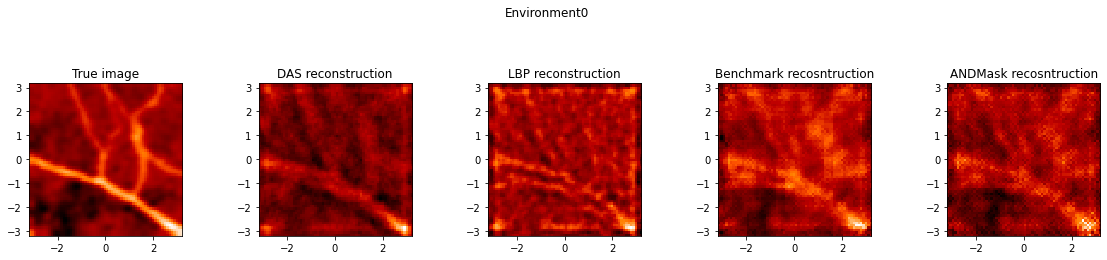

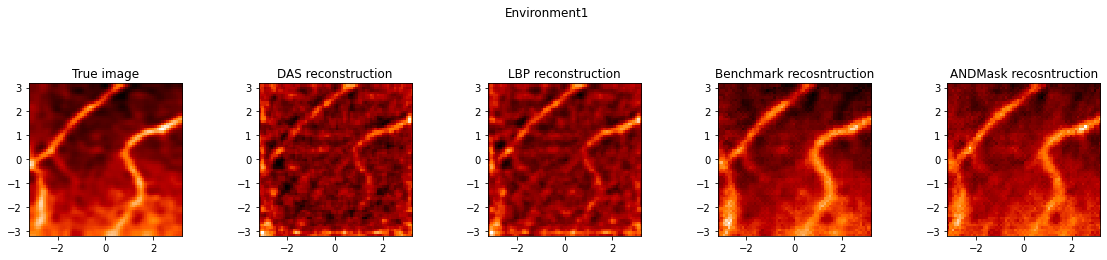

In [14]:
#from importlib import reload 
#import utils.causal_utils 
#reload(utils.causal_utils)
#from utils.causal_utils import testing
testing(np.array(SSIM),np.array(PC),np.array(RMSE),np.array(PSNR),test_loaders, Ao.to(device="cpu"),model, model_nc)